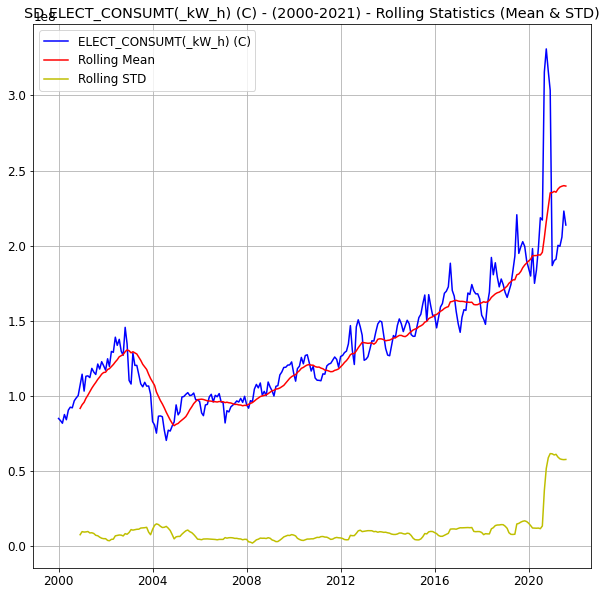

Results of Dickey Fuller Test
Test Statistic            1.360775
p vaue                    0.996928
# Lags Used              11.000000
# of Obs Used           248.000000
Critical Value (1%)      -3.456996
Critical Value (5%)      -2.873266
Critical Value (10%)     -2.573019
dtype: float64


In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.grid']      = True
plt.rcParams['font.size']      = 12

df = pd.read_excel('../time_series_cne_data.xlsx')

sttn, field = ['SD', 'ELECT_CONSUMT(_kW_h)']


if sttn == 'SD':
    sttn = 'Santo Domingo'
    s    = 'SD'
elif sttn == 'DN':
    sttn  = 'Distrito Nacional'
    s     = 'DN' 
else: 
    sttn = 'Gran Santo Domingo'
    s    = 'GSD'
col_name = f'EC_{s}'
# df = df.loc[df['PROV'] == sttn]
df = df[["DATE", col_name]]

df.set_index('DATE', inplace=True)
# #https://itecnote.com/tecnote/python-arima-model-missingdataerror-exog-contains-inf-or-nans/
# df = df.fillna(method='ffill')

def test_stationarity(df, sttn, s, field, col_name, DFT=True):
    #rolling statistics
    window = 12
    rolmean  = df.rolling(window = window).mean()
    rolmean2 = rolmean.rolling(window = window).mean().rolling(window = window).mean()
    # rolmean = rolmean.rolling(window = 365).mean()
    rolstd = df.rolling(window = window).std()#.rolling(window = window).std()
    
    dfplot = plt.plot(df, color='b', label=f'{field} (C)')
    mean  = plt.plot(rolmean, color='r', label='Rolling Mean')
    # mean2 = plt.plot(rolmean2, color='k', label='R-Rolling Mean')
    std  = plt.plot(rolstd, color='y', label='Rolling STD')
    plt.legend(loc='best')
    plt.title(f'{s} {field} (C) - (2000-2021) - Rolling Statistics (Mean & STD)')
    plt.gcf()
    plt.savefig(f'../rolling_{field}_{s}', bbox_inches='tight')
    plt.show(block=False)
        
    if DFT:
        print('Results of Dickey Fuller Test')
        dftest = adfuller(df[col_name], autolag='AIC')

        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p vaue', 
                                        '# Lags Used', '# of Obs Used'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)        
    
test_stationarity(df=df, sttn=sttn, s=s, field=field, col_name=col_name)

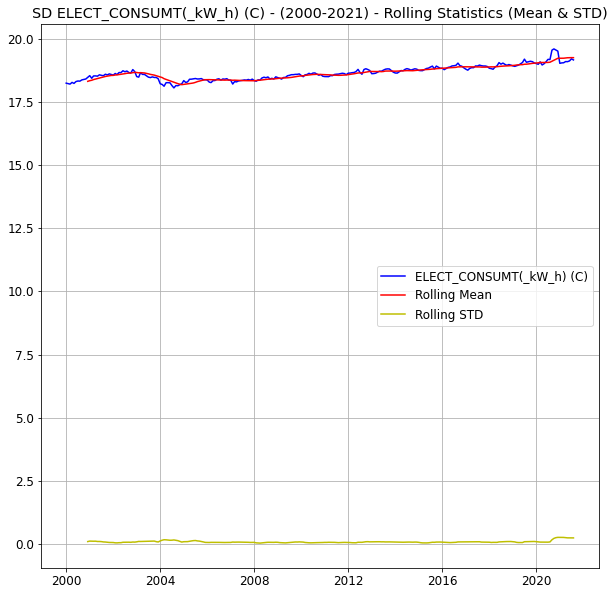

Results of Dickey Fuller Test
Test Statistic           -0.512279
p vaue                    0.889598
# Lags Used              13.000000
# of Obs Used           246.000000
Critical Value (1%)      -3.457215
Critical Value (5%)      -2.873362
Critical Value (10%)     -2.573070
dtype: float64


In [2]:
df_logScale = np.log(df)
test_stationarity(df=df_logScale, sttn=sttn, s=s, field=field, col_name=col_name)

In [3]:
movingAverage = df_logScale.rolling(window=250).mean()
logMinusMovingAvrg = df_logScale - movingAverage

logMinusMovingAvrg.dropna(inplace=True)
logMinusMovingAvrg

,EC_SD
DATE,
2020-10-01,0.970543
2020-11-01,0.919623
2020-12-01,0.873227
2021-01-01,0.385056
2021-02-01,0.399627
2021-03-01,0.401184
2021-04-01,0.445183
2021-05-01,0.438892
2021-06-01,0.465798


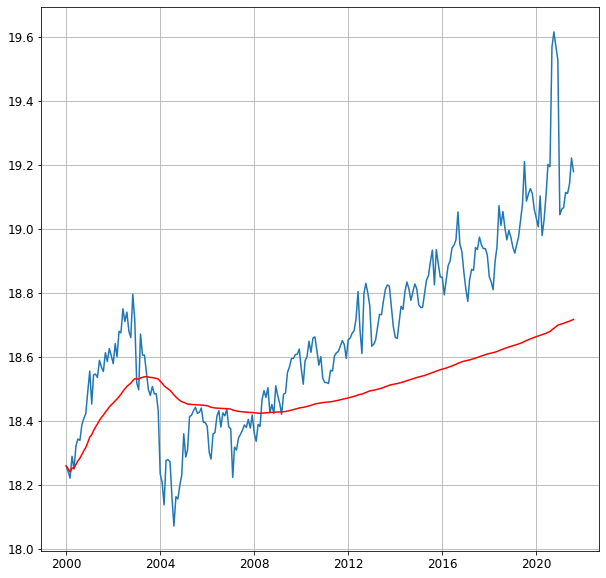

In [4]:
expDecayWeightedAvrg = df_logScale.ewm(halflife=250, min_periods=0,
                                       adjust=True).mean()
plt.plot(df_logScale)
plt.plot(expDecayWeightedAvrg, color='r')
plt.show()

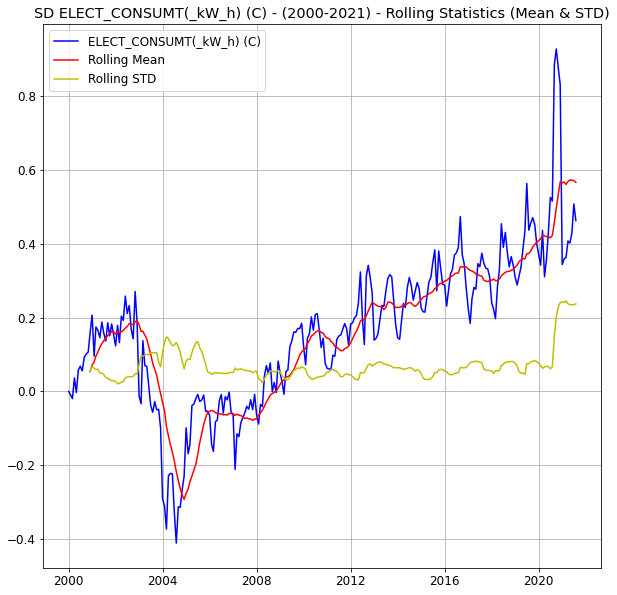

Results of Dickey Fuller Test
Test Statistic           -0.917240
p vaue                    0.782242
# Lags Used              13.000000
# of Obs Used           246.000000
Critical Value (1%)      -3.457215
Critical Value (5%)      -2.873362
Critical Value (10%)     -2.573070
dtype: float64


In [5]:
logScaleMinusEDWA = df_logScale - expDecayWeightedAvrg
test_stationarity(df=logScaleMinusEDWA, sttn=sttn, s=s, 
                  field=field, col_name=col_name)

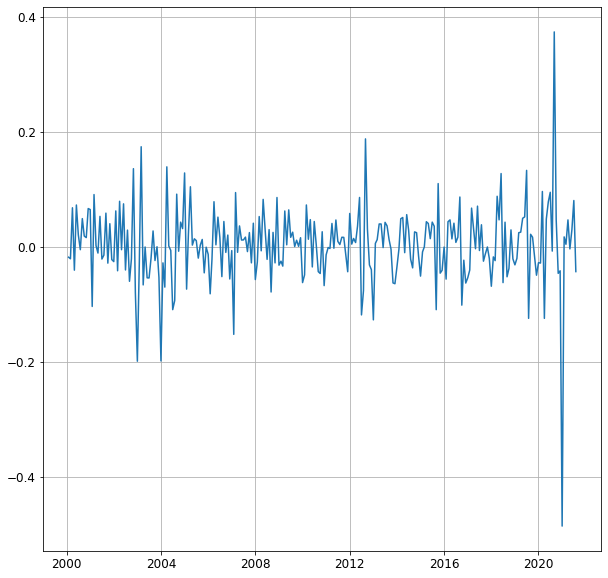

In [6]:
LogDiffShifting = df_logScale - df_logScale.shift()
plt.plot(LogDiffShifting)
plt.show()

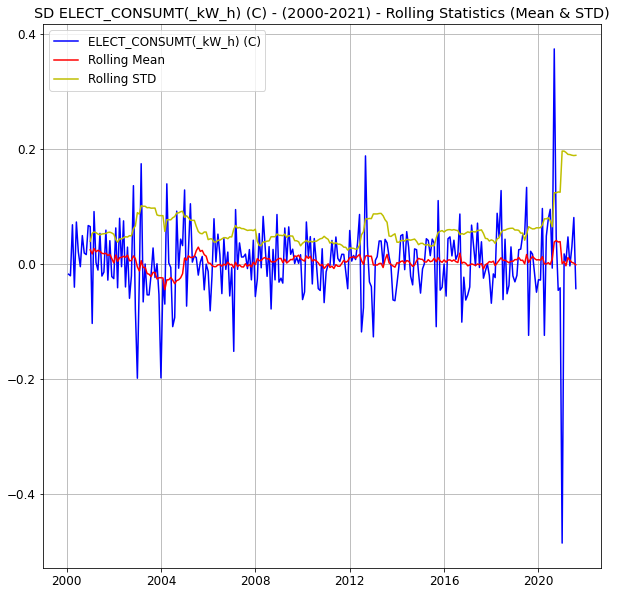

Results of Dickey Fuller Test
Test Statistic           -4.275006
p vaue                    0.000491
# Lags Used              12.000000
# of Obs Used           246.000000
Critical Value (1%)      -3.457215
Critical Value (5%)      -2.873362
Critical Value (10%)     -2.573070
dtype: float64


In [7]:
LogDiffShifting.dropna(inplace=True)
test_stationarity(df=LogDiffShifting, sttn=sttn, s=s, 
                  field=field, col_name=col_name)

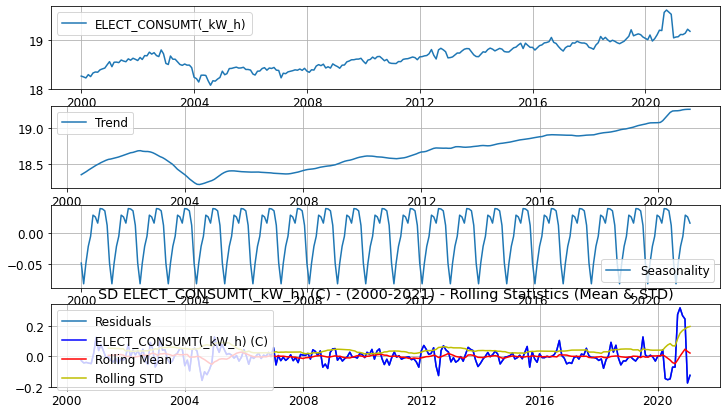

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_logScale)

trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,7))

plt.subplot(411)
plt.plot(df_logScale, label=field)
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

residual.dropna(inplace=True)
test_stationarity(df=residual, sttn=sttn, s=s, 
                  field=field, col_name=col_name, DFT = False)